# No-glue-code

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Cambdrige`


In [2]:
# The statistical inference frame-work we will use
using LogDensityProblems
using LogDensityProblemsAD
using DynamicPPL
using ForwardDiff
using Random
using LinearAlgebra

#Plotting
using PyPlot

#What we are tweaking
using Revise
using AdvancedHMC
using Turing

[ Info: Precompiling AdvancedHMC [0bf59076-c3b1-5ca4-86bd-e02cd72cde3d]
[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]


## Model

In [3]:
# Just a simple Neal Funnel
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DefaultContext()))

## Turing interface

In [5]:
struct Sampler
    metric
    integrator
    adaptor
    proposal
end

Sampler(ϵ::Number, TAP::Number) = begin
    metric =  DiagEuclideanMetric(d)
    integrator = Leapfrog(ϵ)
    proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(TAP, integrator))
    
    Sampler(
        metric,
        integrator,
        adaptor,
        proposal)
end

Sampler

In [6]:
initial_θ = randn(21)
initial_ϵ = 0.1 #find_good_stepsize(hamiltonian, initial_θ)
spl = Sampler(initial_ϵ, 0.95)

Sampler(DiagEuclideanMetric([1.0, 1.0, 1.0, 1.0, 1.0, 1 ...]), Leapfrog(ϵ=0.1), StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.95, state.ϵ=0.1),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
), HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.1), tc=GeneralisedNoUTurn{Float64}(10, 1000.0))))

## Sampling

In [7]:
n_samples, n_adapts = 10_000, 1_000
samples, stats = sample(funnel_model, 0.1, 0.95, n_samples, n_adapts; initial_θ=initial_θ);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:04
  iterations:                                   10000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      31
  is_accept:                                    true
  acceptance_rate:                              0.9977556019563564
  log_density:                                  -55.59669800049129
  hamiltonian_energy:                           76.99245786344844
  hamiltonian_energy_error:                     -0.037907257288452456
  max_hamil

## Plotting

In [8]:
theta_mchmc = [sample[1] for sample in samples]
x10_mchmc = [sample[10+1] for sample in samples];

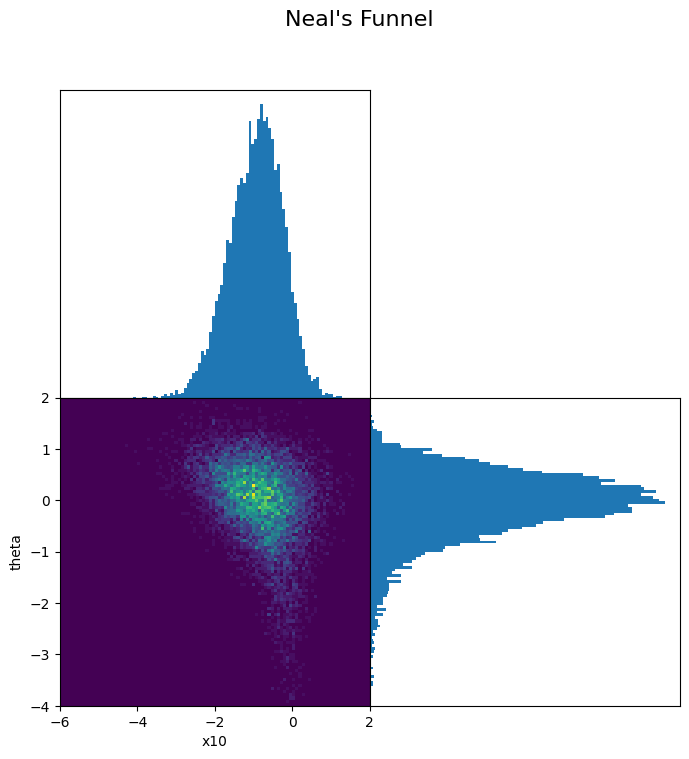

In [9]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## Sampling w AbstractMCMC

In [15]:
initial_ϵ=0.1 
TAP=0.95
ss = AdvancedHMC.HMCSamplerSettings(initial_ϵ, TAP)

AdvancedHMC.HMCSamplerSettings(0.1, 0.95)

In [16]:
sample(funnel_model, ss, 1000)

LoadError: MethodError: no method matching sample(::Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}, ::AdvancedHMC.HMCSamplerSettings, ::Int64)

[0mClosest candidates are:
[0m  sample(::Model, [91m::Number[39m, ::Number, [91m::Int64[39m, [91m::Int64[39m; initial_θ, progress, kwargs...)
[0m[90m   @[39m [33mAdvancedHMC[39m [90m~/Cambdrige/AdvancedHMC.jl/src/[39m[90m[4msampler.jl:177[24m[39m
[0m  sample([91m::AbstractMCMC.LogDensityModel[39m, ::AdvancedHMC.HMCSamplerSettings, ::Integer; progress, verbose, callback, kwargs...)
[0m[90m   @[39m [33mAdvancedHMC[39m [90m~/Cambdrige/AdvancedHMC.jl/src/[39m[90m[4mabstractmcmc.jl:64[24m[39m
[0m  sample(::Any, [91m::AbstractMCMC.AbstractSampler[39m, ::Any; kwargs...)
[0m[90m   @[39m [36mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/bE6VB/src/[39m[90m[4msample.jl:15[24m[39m
[0m  ...


## Sampling w Turing

In [12]:
using Turing

In [13]:
TAP = 0.95
nadapts = 300
spl = Turing.NUTS(nadapts, TAP)

Turing.Inference.NUTS{Turing.Essential.ForwardDiffAD{0}, (), DiagEuclideanMetric}(300, 0.95, 10, 1000.0, 0.0)

In [14]:
Turing.sample(funnel_model, spl, 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 1.6
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:11


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 301:1:50300
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 14.4 seconds
Compute duration  = 14.4 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ   -0.0346    0.7783    0.0140    5113.3278    2765.1043    1.0000 ⋯
        z[1]    0.6049    0.7333    0.0040   34483.1850   32515.8682    1.0000 ⋯
        z[2]    0.6175    0.7356    0.0035   46810.9217   33380.6290    1.0001 ⋯
        z[3]   -0.42